In [1]:
import pandas as pd

train_df = pd.read_csv('data/features/feat_train_total_msrp.csv')
test_df = pd.read_csv('data/features/feat_test_total_msrp.csv')
test_100_df = pd.read_csv('data/features/feat_test_100_total_msrp.csv')

train_df = train_df[['amr1','amr2','label']]
test_100_df = test_100_df[['amr1','amr2','label']]
test_df = test_df[['amr1','amr2','label']]

In [2]:
import string
import penman

def extract_concepts(amr):
    graph = penman.decode(amr)
    words = [node[2] for node in graph.instances()]
    # words = [word.replace('-', '').rstrip('0123456789') for word in words]
    for triple in graph.triples:
        if triple[1].startswith((":op", ":time")):
            if triple[2][0] == "z" and not triple[2][1:].isdigit():
                words.append(triple[2])
            elif triple[2][0] != "z":
                words.append(triple[2])
        elif triple[1].startswith(":wiki") and triple[2] != "-":
            words.append(triple[2])
    return words



In [3]:
train_df['concepts_amr1'] = train_df['amr1'].apply(extract_concepts)
train_df['concepts_amr2'] = train_df['amr2'].apply(extract_concepts)
train_df['concepts_amr1'] = train_df['concepts_amr1'].apply(' '.join)
train_df['concepts_amr2'] = train_df['concepts_amr2'].apply(' '.join)


test_100_df['concepts_amr1'] = test_100_df['amr1'].apply(extract_concepts)
test_100_df['concepts_amr2'] = test_100_df['amr2'].apply(extract_concepts)
test_100_df['concepts_amr1'] = test_100_df['concepts_amr1'].apply(' '.join)
test_100_df['concepts_amr2'] = test_100_df['concepts_amr2'].apply(' '.join)

test_df['concepts_amr1'] = test_df['amr1'].apply(extract_concepts)
test_df['concepts_amr2'] = test_df['amr2'].apply(extract_concepts)
test_df['concepts_amr1'] = test_df['concepts_amr1'].apply(' '.join)
test_df['concepts_amr2'] = test_df['concepts_amr2'].apply(' '.join)


cannot deinvert attribute: ('z8', ':part-of', 'z5')
ignoring epigraph data for duplicate triple: ('z3', ':wiki', '-')
ignoring epigraph data for duplicate triple: ('z0', ':ARG0', 'z1')
ignoring epigraph data for duplicate triple: ('z7', ':wiki', '-')
ignoring epigraph data for duplicate triple: ('z3', ':wiki', '-')
ignoring epigraph data for duplicate triple: ('z3', ':wiki', '-')
ignoring epigraph data for duplicate triple: ('z1005', ':op1', '"entitas-laju"')
ignoring epigraph data for duplicate triple: ('z1005', ':value', '"entitas-ordinal"')
ignoring epigraph data for duplicate triple: ('z1005', ':value', '"entitas-ordinal"')
ignoring epigraph data for duplicate triple: ('z1005', ':value', '"entitas-ordinal"')
ignoring epigraph data for duplicate triple: ('z1005', ':value', '"entitas-ordinal"')
ignoring epigraph data for duplicate triple: ('z1005', ':value', '"entitas-ordinal"')
ignoring epigraph data for duplicate triple: ('z1033', ':op1', '"entitas-lajualannama"')
ignoring epigraph

In [4]:

import numpy as np
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import vstack, hstack

def extr_feat(df_train, df_test, factor=True, n_comp=100, inductive=True):
    df_train = df_train.copy()
    df_test = df_test.copy()
    if inductive:
        all_sent = np.concatenate([df_train['concepts_amr1'], df_train['concepts_amr2']])
    else:
        all_sent = np.concatenate([df_train['concepts_amr1'], df_train['concepts_amr2'],
                                    df_test['concepts_amr1'], df_test['concepts_amr2']])
    vec = TfidfVectorizer(token_pattern=r'\b\w[\w-]*\b')
    vec.fit(all_sent)

    X1_train = vec.transform(df_train['concepts_amr1'])
    X2_train = vec.transform(df_train['concepts_amr2'])
    X_train = vstack((X1_train, X2_train))
    
    X1_test = vec.transform(df_test['concepts_amr1'])
    X2_test = vec.transform(df_test['concepts_amr2'])

    print("vocab size:" ,len(vec.vocabulary_))
    if (factor):
        n_components = math.floor(n_comp * len(vec.vocabulary_))
    else:
        n_components = n_comp
    lsa = TruncatedSVD(n_components=n_components, random_state=42)
    X_train = lsa.fit_transform(X_train)
    
    X_train = np.vsplit(X_train, 2)
    sum_res = X_train[0] + X_train[1]
    diff_res = np.abs(X_train[0] - X_train[1])
    feat_1_train = np.column_stack((sum_res, diff_res))
    lsa_df_train = pd.DataFrame(feat_1_train.tolist(), columns=[f'f{i}' for i in range(feat_1_train.shape[1])], index=df_train.index)
    lsa_df_train['label'] = df_train['label']

    X1_test = lsa.transform(X1_test)
    X2_test = lsa.transform(X2_test)
    sum_res = X1_test + X2_test
    diff_res = np.abs(X1_test - X2_test)
    feat_1_test = np.column_stack((sum_res, diff_res))
    lsa_df_test = pd.DataFrame(feat_1_test.tolist(), columns=[f'f{i}' for i in range(feat_1_test.shape[1])], index=df_test.index)
    lsa_df_test['label'] = df_test['label']
    
    return lsa_df_train, lsa_df_test


# Best Model start

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.9s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   4.1s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample

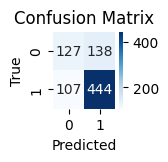

In [10]:
import classifiers.lgbm as lgbm

train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=3/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_train_lgbm(X_train, y_train, param=param)


In [17]:
train.to_csv("data/features/feat_exp_3_a_train.csv", index=False)

In [18]:
test.to_csv("data/features/feat_exp_3_a_test_100.csv", index=False)


In [15]:
import joblib

joblib.dump(model, 'model/best_model_lsa_tfidf.joblib')
# model.save_model('model/best_model_lsa_tfidf.txt')

['model/best_model_lsa_tfidf.joblib']

Akurasi: 0.700
Presisi: 0.653
Recall: 0.643
F1 validasi: 0.646
Confusion Matrix:
[[127 138]
 [107 444]]


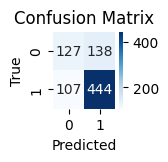

Akurasi model terbaik: 0.640
Precision model terbaik: 0.636
Recall model terbaik: 0.628
F1 pengujian model terbaik: 0.628
Confusion Matrix:
[[23 22]
 [14 41]]


In [16]:
import joblib
# Load the model from the file using joblib
loaded_model = joblib.load('model/best_model_lsa_tfidf.joblib')

X_test = test.drop(columns=['label'])
y_test = test['label']
# Use the loaded model for predictions
predictions = loaded_model.predict(X_test)
from evaluation_matrics import print_validasi, print_score_uji

print_validasi(loaded_model, X_train, y_train)
print_score_uji(y_test, predictions, loaded_model)

vocab size: 12112
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.4s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.4s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample

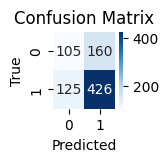

In [6]:
import classifiers.lgbm as lgbm

train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=3/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_train_lgbm(X_train, y_train, param=param)


In [14]:
import classifiers.lgbm as lgbm

train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=3/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_and_test_lgbm(X_train, y_train, X_test, y_test, param=param)


vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.2s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.4s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample

In [1]:
import classifiers.lgbm as lgbm

train, test = extr_feat(train_df, test_df, factor=True, n_comp=3/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_train_lgbm(X_train, y_train, param=param)


NameError: name 'extr_feat' is not defined

In [15]:
test.to_csv("data/features/feat_exp_3_a_test.csv", index=False)


In [16]:
import joblib

joblib.dump(model, 'model/best_model_lsa_tfidf.pkl')

['model/best_model_lsa_tfidf.pkl']

vocab size: 14675
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   5.0s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   6.5s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample

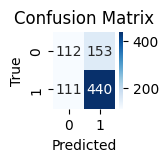

In [8]:
import classifiers.lgbm as lgbm

train, test = extr_feat(train_df, test_df, factor=True, n_comp=3/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_train_lgbm(X_train, y_train, param=param)


# Best Model end

In [8]:
train = extr_feat(amr_msrp, factor=True, n_comp=10/100)

X_train = train.drop(columns=['label'])
y_train = train['label']

vocab size: 11473


[I 2024-06-29 10:19:14,947] A new study created in memory with name: no-name-e61691cd-9d37-42d1-af5e-c82fade63054
[I 2024-06-29 10:19:35,605] Trial 0 finished with value: 0.5798303263678652 and parameters: {'svc__C': 1.0, 'svc__kernel': 'linear', 'svc__gamma': 1.0, 'svc__degree': 3}. Best is trial 0 with value: 0.5798303263678652.
[I 2024-06-29 10:19:52,432] Trial 1 finished with value: 0.5967447085271061 and parameters: {'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}. Best is trial 1 with value: 0.5967447085271061.
[I 2024-06-29 10:20:08,538] Trial 2 finished with value: 0.5305185903679452 and parameters: {'svc__C': 0.01112624702562852, 'svc__kernel': 'linear', 'svc__gamma': 0.1750845714676601, 'svc__degree': 3}. Best is trial 1 with value: 0.5967447085271061.
[I 2024-06-29 10:20:22,117] Trial 3 finished with value: 0.5700318857082389 and parameters: {'svc__C': 19.5559856651721, 'svc__kernel': 'poly', 'svc__gamma': 6.562799

Akurasi: 0.645
Presisi: 0.600
Recall: 0.604
F1 validasi: 0.602
Confusion Matrix:
[[129 136]
 [154 397]]


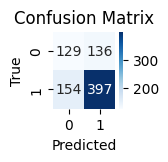

{'svc__C': 0.46241983022096295, 'svc__kernel': 'rbf', 'svc__gamma': 0.08542502176543637, 'svc__degree': 3}


In [10]:
import classifiers.svm as svm

list_param = [{'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}]
gs, model = svm.find_best_param_svm(X_train, y_train, n_trials=100, timeout=300, list_param=list_param)

[I 2024-06-25 07:48:37,891] A new study created in memory with name: no-name-8fa4d213-e4ca-4285-b2f5-a783a56d7f62
[I 2024-06-25 07:48:52,376] Trial 0 finished with value: 0.5798303263678652 and parameters: {'svc__C': 1.0, 'svc__kernel': 'linear', 'svc__gamma': 1.0, 'svc__degree': 3}. Best is trial 0 with value: 0.5798303263678652.
[I 2024-06-25 07:49:09,383] Trial 1 finished with value: 0.5967447085271061 and parameters: {'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}. Best is trial 1 with value: 0.5967447085271061.
[I 2024-06-25 07:49:25,167] Trial 2 finished with value: 0.5852258189251666 and parameters: {'svc__C': 0.35755372181254935, 'svc__kernel': 'linear', 'svc__gamma': 4.268450262837259, 'svc__degree': 3}. Best is trial 1 with value: 0.5967447085271061.
[I 2024-06-25 07:49:44,980] Trial 3 finished with value: 0.43649802798416315 and parameters: {'svc__C': 684.7968883012452, 'svc__kernel': 'poly', 'svc__gamma': 0.00046

Akurasi: 0.629
Presisi: 0.573
Recall: 0.571
F1 validasi: 0.572
Confusion Matrix:
[[108 157]
 [146 405]]


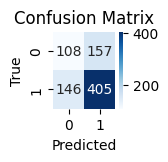

{'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}


In [8]:
import classifiers.svm as svm

list_param = [{'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}]
gs, model = svm.find_best_param_svm(X_train, y_train, n_trials=100, timeout=300, list_param=list_param)


[I 2024-06-25 07:59:55,268] A new study created in memory with name: no-name-02695eb7-2cb4-4cb8-9099-d92a1074bce6
[I 2024-06-25 08:00:16,599] Trial 0 finished with value: 0.5798303263678652 and parameters: {'svc__C': 1.0, 'svc__kernel': 'linear', 'svc__gamma': 1.0, 'svc__degree': 3}. Best is trial 0 with value: 0.5798303263678652.
[I 2024-06-25 08:00:33,968] Trial 1 finished with value: 0.5967447085271061 and parameters: {'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}. Best is trial 1 with value: 0.5967447085271061.
[I 2024-06-25 08:00:52,842] Trial 2 finished with value: 0.41682690116549653 and parameters: {'svc__C': 0.04842217317078697, 'svc__kernel': 'poly', 'svc__gamma': 0.3521315835626655, 'svc__degree': 5}. Best is trial 1 with value: 0.5967447085271061.
[I 2024-06-25 08:01:10,804] Trial 3 finished with value: 0.4605137304856929 and parameters: {'svc__C': 0.0024218904871838648, 'svc__kernel': 'poly', 'svc__gamma': 0.08

Akurasi: 0.629
Presisi: 0.573
Recall: 0.571
F1 validasi: 0.572
Confusion Matrix:
[[108 157]
 [146 405]]


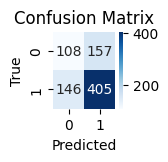

{'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}


In [9]:
import classifiers.svm as svm

list_param = [{'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}]
gs, model = svm.find_best_param_svm(X_train, y_train, n_trials=100, timeout=300, list_param=list_param)


In [10]:
for i in range (1,11):
    print(i/100)

0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1


In [11]:
import classifiers.svm as svm
list_i = []
list_f1_svm = []
for i in range(1, 11):
    train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=i/100, inductive=True)
    X_train = train.drop(columns=['label'])
    y_train = train['label']
    param = {'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}
    param = {k:[v] for k,v in param.items()}
    gs, model, f1 = svm.fit_train_loop_svm(X_train, y_train, param=param)
    list_i.append(i)
    list_f1_svm.append(f1)
    print(i)

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=   5.6s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=   4.9s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=   7.4s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=   4.6s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=   4.5s
1
vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  11.9s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; to

In [12]:
list_i[list_f1_svm.index(max(list_f1_svm))]

8

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  27.6s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  27.6s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  29.9s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  23.4s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  26.9s
Akurasi: 0.672
Presisi: 0.625
Recall: 0.624
F1 validasi: 0.624
Confusion Matrix:
[[129 136]
 [132 419]]


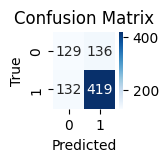

In [13]:
import classifiers.svm as svm
train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=8/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}
param = {k:[v] for k,v in param.items()}
gs, model= svm.fit_train_svm(X_train, y_train, param=param)
    

vocab size: 12112
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  24.7s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  25.6s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  31.7s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  25.6s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  27.1s
Akurasi: 0.646
Presisi: 0.597
Recall: 0.597
F1 validasi: 0.597
Confusion Matrix:
[[121 144]
 [145 406]]


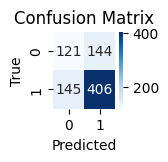

In [14]:
import classifiers.svm as svm
train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=8/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}
param = {k:[v] for k,v in param.items()}
gs, model= svm.fit_train_svm(X_train, y_train, param=param)
    

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  23.5s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  23.9s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  23.8s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  23.3s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  23.9s
Akurasi: 0.672
Presisi: 0.625
Recall: 0.624
F1 validasi: 0.624
Confusion Matrix:
[[129 136]
 [132 419]]


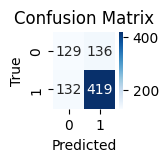

In [28]:
import classifiers.svm as svm
train, test = extr_feat(train_df, test_df, factor=True, n_comp=8/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}
param = {k:[v] for k,v in param.items()}
gs, model= svm.fit_train_svm(X_train, y_train, param=param)
    

vocab size: 14675
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  40.0s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  37.6s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  38.6s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  33.1s
[CV] END svc__C=0.09897676358172126, svc__degree=3, svc__gamma=0.03963846560023219, svc__kernel=linear; total time=  30.2s
Akurasi: 0.670
Presisi: 0.618
Recall: 0.611
F1 validasi: 0.613
Confusion Matrix:
[[117 148]
 [121 430]]


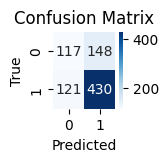

In [15]:
import classifiers.svm as svm
train, test = extr_feat(train_df, test_df, factor=True, n_comp=8/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'svc__C': 0.09897676358172126, 'svc__kernel': 'linear', 'svc__gamma': 0.03963846560023219, 'svc__degree': 3}
param = {k:[v] for k,v in param.items()}
gs, model= svm.fit_train_svm(X_train, y_train, param=param)
    

# XGB

In [12]:
train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=1/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']

vocab size: 11961


In [9]:
import classifiers.xgb as xgb 

gs, model = xgb.find_best_param_xgb(X_train, y_train, n_trials=200, timeout=300)


[I 2024-07-20 22:15:53,543] A new study created in memory with name: no-name-c7bdc2c9-fbe9-4b02-8998-121c5a85b5a2
[I 2024-07-20 22:16:35,374] Trial 0 finished with value: 0.585890373107661 and parameters: {'xgbclassifier__eta': 0.3, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__subsample': 1.0, 'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 0.0, 'xgbclassifier__reg_lambda': 1.0, 'xgbclassifier__objective': 'reg:squarederror'}. Best is trial 0 with value: 0.585890373107661.
[I 2024-07-20 22:17:20,262] Trial 1 finished with value: 0.5733190633036983 and parameters: {'xgbclassifier__eta': 0.04036099300403945, 'xgbclassifier__n_estimators': 729, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.09003737727121203, 'xgbclassifier__subsample': 0.84465155841118, 'xgbclassifier__colsample_bytree': 0.5578144347713982, 'xgbclassifier__min_child_weight': 1

KeyboardInterrupt: 

[I 2024-06-25 09:56:55,945] A new study created in memory with name: no-name-96699a74-511c-4571-8c87-571c63b2aecb
[I 2024-06-25 09:57:23,272] Trial 0 finished with value: 0.5743830139855663 and parameters: {'xgbclassifier__eta': 0.3, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__subsample': 1.0, 'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 0.0, 'xgbclassifier__reg_lambda': 1.0, 'xgbclassifier__objective': 'reg:squarederror'}. Best is trial 0 with value: 0.5743830139855663.
[I 2024-06-25 09:57:48,434] Trial 1 finished with value: 0.5690404369606894 and parameters: {'xgbclassifier__eta': 0.10956403322577613, 'xgbclassifier__n_estimators': 389, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.011943270788670229, 'xgbclassifier__subsample': 0.5322246273506048, 'xgbclassifier__colsample_bytree': 0.7645849850697513, 'xgbclassifier__min_child_weigh

Akurasi: 0.697
Presisi: 0.645
Recall: 0.619
F1 validasi: 0.625
Confusion Matrix:
[[105 160]
 [ 87 464]]


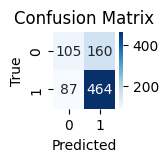

{'xgbclassifier__eta': 0.16711198721853227, 'xgbclassifier__n_estimators': 257, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.039654562175411974, 'xgbclassifier__subsample': 0.7579016529149689, 'xgbclassifier__colsample_bytree': 0.8763452372324041, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__gamma': 0.9387340795079019, 'xgbclassifier__reg_lambda': 1.7342537123889923, 'xgbclassifier__objective': 'binary:logistic'}


In [17]:
import classifiers.xgb as xgb 

gs, model = xgb.find_best_param_xgb(X_train, y_train, n_trials=100, timeout=300)


[I 2024-06-25 10:06:29,193] A new study created in memory with name: no-name-a48d7b42-861b-4b82-80da-a550405eb929
[I 2024-06-25 10:06:51,241] Trial 0 finished with value: 0.5743830139855663 and parameters: {'xgbclassifier__eta': 0.3, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__subsample': 1.0, 'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__gamma': 0.0, 'xgbclassifier__reg_lambda': 1.0, 'xgbclassifier__objective': 'reg:squarederror'}. Best is trial 0 with value: 0.5743830139855663.
[I 2024-06-25 10:07:17,067] Trial 1 finished with value: 0.5690404369606894 and parameters: {'xgbclassifier__eta': 0.10956403322577613, 'xgbclassifier__n_estimators': 389, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.011943270788670229, 'xgbclassifier__subsample': 0.5322246273506048, 'xgbclassifier__colsample_bytree': 0.7645849850697513, 'xgbclassifier__min_child_weigh

Akurasi: 0.697
Presisi: 0.645
Recall: 0.619
F1 validasi: 0.625
Confusion Matrix:
[[105 160]
 [ 87 464]]


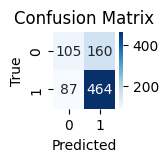

{'xgbclassifier__eta': 0.16711198721853227, 'xgbclassifier__n_estimators': 257, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.039654562175411974, 'xgbclassifier__subsample': 0.7579016529149689, 'xgbclassifier__colsample_bytree': 0.8763452372324041, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__gamma': 0.9387340795079019, 'xgbclassifier__reg_lambda': 1.7342537123889923, 'xgbclassifier__objective': 'binary:logistic'}


In [18]:

import classifiers.xgb as xgb 

list_param = [{'xgbclassifier__eta': 0.16711198721853227, 'xgbclassifier__n_estimators': 257, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.039654562175411974, 'xgbclassifier__subsample': 0.7579016529149689, 'xgbclassifier__colsample_bytree': 0.8763452372324041, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__gamma': 0.9387340795079019, 'xgbclassifier__reg_lambda': 1.7342537123889923, 'xgbclassifier__objective': 'binary:logistic'}]
gs, model = xgb.find_best_param_xgb(X_train, y_train, n_trials=100, timeout=300, list_param=list_param)

In [19]:
import classifiers.xgb as xgb
list_i = []
list_f1_xgb = []
for i in range(1, 11):
    train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=i/100, inductive=True)
    X_train = train.drop(columns=['label'])
    y_train = train['label']
    param = {'xgbclassifier__eta': 0.16711198721853227, 'xgbclassifier__n_estimators': 257, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.039654562175411974, 'xgbclassifier__subsample': 0.7579016529149689, 'xgbclassifier__colsample_bytree': 0.8763452372324041, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__gamma': 0.9387340795079019, 'xgbclassifier__reg_lambda': 1.7342537123889923, 'xgbclassifier__objective': 'binary:logistic'}
    param = {k:[v] for k,v in param.items()}
    gs, model, f1 = xgb.fit_train_loop_xgb(X_train, y_train, param=param)
    list_i.append(i)
    list_f1_xgb.append(f1)
    print(i)

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  17.6s
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  17.8s
[CV] END xgbclassifier__colsample_bytree=

In [20]:
list_i[list_f1_xgb.index(max(list_f1_xgb))]


1

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  18.8s
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  19.5s
[CV] END xgbclassifier__colsample_bytree=

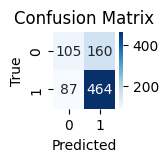

In [21]:
import classifiers.xgb as xgb
train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=1/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'xgbclassifier__eta': 0.16711198721853227, 'xgbclassifier__n_estimators': 257, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.039654562175411974, 'xgbclassifier__subsample': 0.7579016529149689, 'xgbclassifier__colsample_bytree': 0.8763452372324041, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__gamma': 0.9387340795079019, 'xgbclassifier__reg_lambda': 1.7342537123889923, 'xgbclassifier__objective': 'binary:logistic'}
param = {k:[v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)
    

vocab size: 12112
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  54.9s
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  48.4s
[CV] END xgbclassifier__colsample_bytree=

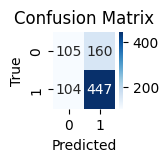

In [22]:
import classifiers.xgb as xgb
train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=1/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'xgbclassifier__eta': 0.16711198721853227, 'xgbclassifier__n_estimators': 257, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.039654562175411974, 'xgbclassifier__subsample': 0.7579016529149689, 'xgbclassifier__colsample_bytree': 0.8763452372324041, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__gamma': 0.9387340795079019, 'xgbclassifier__reg_lambda': 1.7342537123889923, 'xgbclassifier__objective': 'binary:logistic'}
param = {k:[v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)
    

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  19.6s
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  18.7s
[CV] END xgbclassifier__colsample_bytree=

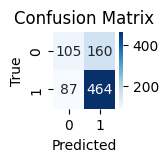

In [27]:
import classifiers.xgb as xgb
train, test = extr_feat(train_df, test_df, factor=True, n_comp=1/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'xgbclassifier__eta': 0.16711198721853227, 'xgbclassifier__n_estimators': 257, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.039654562175411974, 'xgbclassifier__subsample': 0.7579016529149689, 'xgbclassifier__colsample_bytree': 0.8763452372324041, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__gamma': 0.9387340795079019, 'xgbclassifier__reg_lambda': 1.7342537123889923, 'xgbclassifier__objective': 'binary:logistic'}
param = {k:[v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)
    

vocab size: 14675
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  23.1s
[CV] END xgbclassifier__colsample_bytree=0.8763452372324041, xgbclassifier__eta=0.16711198721853227, xgbclassifier__gamma=0.9387340795079019, xgbclassifier__learning_rate=0.039654562175411974, xgbclassifier__max_depth=7, xgbclassifier__min_child_weight=2, xgbclassifier__n_estimators=257, xgbclassifier__objective=binary:logistic, xgbclassifier__reg_lambda=1.7342537123889923, xgbclassifier__subsample=0.7579016529149689; total time=  40.4s
[CV] END xgbclassifier__colsample_bytree=

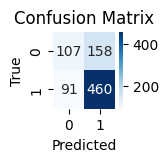

In [23]:
import classifiers.xgb as xgb
train, test = extr_feat(train_df, test_df, factor=True, n_comp=1/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'xgbclassifier__eta': 0.16711198721853227, 'xgbclassifier__n_estimators': 257, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.039654562175411974, 'xgbclassifier__subsample': 0.7579016529149689, 'xgbclassifier__colsample_bytree': 0.8763452372324041, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__gamma': 0.9387340795079019, 'xgbclassifier__reg_lambda': 1.7342537123889923, 'xgbclassifier__objective': 'binary:logistic'}
param = {k:[v] for k,v in param.items()}
gs, model = xgb.fit_train_xgb(X_train, y_train, param=param)
    

## RF

In [13]:
train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=1/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']

vocab size: 11961


[I 2024-06-29 12:48:02,167] A new study created in memory with name: no-name-941f620c-91df-485c-a688-6281bef015d9


[I 2024-06-29 12:48:24,015] Trial 0 finished with value: 0.5869333863103577 and parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 1000, 'randomforestclassifier__bootstrap': True}. Best is trial 0 with value: 0.5869333863103577.
[I 2024-06-29 12:49:12,041] Trial 1 finished with value: 0.595711018246716 and parameters: {'randomforestclassifier__n_estimators': 765, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 67, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 52, 'randomforestclassifier__bootstrap': True}. Best is trial 1 with value: 0.595711018246716.
[I 2024-06-29 12:49:46,751] Trial 2 finished with value: 0.5956632836915144 and parameters: {'randomforestclassifier__n_estimators': 313, 'randomforestclassifier__max_features': '

Akurasi: 0.676
Presisi: 0.626
Recall: 0.620
F1 validasi: 0.623
Confusion Matrix:
[[122 143]
 [121 430]]


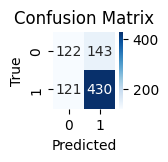

{'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}


In [14]:
import classifiers.rf as rf

gs, model = rf.find_best_param_rf(X_train, y_train, n_trials=100, timeout=300)


In [17]:
import classifiers.rf as rf

list_param = [{'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}]
gs, model = rf.find_best_param_rf(X_train, y_train, n_trials=100, timeout=300, list_param=list_param)


[I 2024-06-29 13:34:49,568] A new study created in memory with name: no-name-1ffdd074-2e4e-4190-8172-3af08bfd78ec
[I 2024-06-29 13:35:10,196] Trial 0 finished with value: 0.5869333863103577 and parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 1000, 'randomforestclassifier__bootstrap': True}. Best is trial 0 with value: 0.5869333863103577.
[I 2024-06-29 13:35:25,348] Trial 1 finished with value: 0.6075438954747123 and parameters: {'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}. Best is trial 1 with value: 0.6075438954747123.
[W 2024-06-29 13:47:16,305] Trial 2 failed with parameters:

KeyboardInterrupt: 

[I 2024-06-29 14:30:06,004] A new study created in memory with name: no-name-61d49ccf-b300-4ece-899c-65ca2cefeced
[I 2024-06-29 14:30:35,552] Trial 0 finished with value: 0.5869333863103577 and parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': 1000, 'randomforestclassifier__bootstrap': True}. Best is trial 0 with value: 0.5869333863103577.
[I 2024-06-29 14:30:55,086] Trial 1 finished with value: 0.6075438954747123 and parameters: {'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}. Best is trial 1 with value: 0.6075438954747123.
[I 2024-06-29 14:38:53,732] Trial 2 finished with value: 0.

Akurasi: 0.676
Presisi: 0.626
Recall: 0.620
F1 validasi: 0.623
Confusion Matrix:
[[122 143]
 [121 430]]


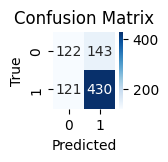

{'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}


In [18]:
import classifiers.rf as rf

list_param = [{'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}]
gs, model = rf.find_best_param_rf(X_train, y_train, n_trials=100, timeout=300, list_param=list_param)


In [19]:
import classifiers.rf as rf
list_i = []
list_f1_rf = []
for i in range(1, 11):
    train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=i/100, inductive=True)
    X_train = train.drop(columns=['label'])
    y_train = train['label']
    param = {'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}
    param = {k:[v] for k,v in param.items()}
    gs, model, f1 = rf.fit_train_loop_rf(X_train, y_train, param=param)
    list_i.append(i)
    list_f1_rf.append(f1)
    print(i)

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   5.3s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   7.0s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   6.9s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entro

In [20]:
list_i[list_f1_rf.index(max(list_f1_rf))]

3

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   9.1s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   9.0s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   9.4s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entro

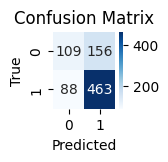

In [22]:
import classifiers.rf as rf
train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=3/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}
param = {k:[v] for k,v in param.items()}
gs, model = rf.fit_train_rf(X_train, y_train, param=param)

vocab size: 12112
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   8.9s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   8.9s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   8.9s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entro

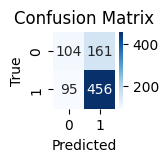

In [24]:
import classifiers.rf as rf
train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=3/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}
param = {k:[v] for k,v in param.items()}
gs, model = rf.fit_train_rf(X_train, y_train, param=param)

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=  11.0s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   8.7s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=  10.7s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entro

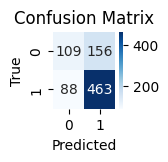

In [25]:
import classifiers.rf as rf
train, test = extr_feat(train_df, test_df, factor=True, n_comp=3/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}
param = {k:[v] for k,v in param.items()}
gs, model = rf.fit_train_rf(X_train, y_train, param=param)

vocab size: 14675
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   8.8s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=   9.2s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=11, randomforestclassifier__max_features=log2, randomforestclassifier__max_leaf_nodes=59, randomforestclassifier__n_estimators=121; total time=  10.4s
[CV] END randomforestclassifier__bootstrap=False, randomforestclassifier__criterion=entro

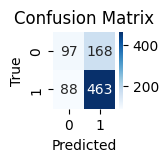

In [26]:
import classifiers.rf as rf
train, test = extr_feat(train_df, test_df, factor=True, n_comp=3/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'randomforestclassifier__n_estimators': 121, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_leaf_nodes': 59, 'randomforestclassifier__bootstrap': False}
param = {k:[v] for k,v in param.items()}
gs, model = rf.fit_train_rf(X_train, y_train, param=param)

# LGBM

In [9]:
import classifiers.lgbm as lgbm

_, _ = lgbm.find_best_param_lgbm(X_train, y_train, timeout=300)

[I 2024-07-20 22:34:17,570] A new study created in memory with name: no-name-bde98878-ea4b-47dc-b164-bf504a7bde66
[I 2024-07-20 22:36:33,841] Trial 0 finished with value: 0.5959686895278139 and parameters: {'lgbmclassifier__num_leaves': 31, 'lgbmclassifier__min_data_in_leaf': 20, 'lgbmclassifier__max_depth': -1, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__n_estimators': 100, 'lgbmclassifier__subsample': 1.0, 'lgbmclassifier__colsample_bytree': 1.0, 'lgbmclassifier__reg_alpha': 0.0, 'lgbmclassifier__reg_lambda': 0.0, 'lgbmclassifier__boosting': 'gbdt'}. Best is trial 0 with value: 0.5959686895278139.
[W 2024-07-20 22:36:43,604] Trial 1 failed with parameters: {'lgbmclassifier__num_leaves': 89, 'lgbmclassifier__min_data_in_leaf': 91, 'lgbmclassifier__max_depth': 12, 'lgbmclassifier__learning_rate': 0.19481954982835353, 'lgbmclassifier__n_estimators': 273, 'lgbmclassifier__subsample': 0.5510264466529325, 'lgbmclassifier__colsample_bytree': 0.5175127559592309, 'lgbmclassifier__r

KeyboardInterrupt: 

vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   4.1s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   4.2s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample

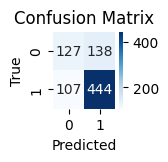

In [8]:
import classifiers.lgbm as lgbm

train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=3/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_train_lgbm(X_train, y_train, param=param)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   1.8s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   1.5s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.64394251

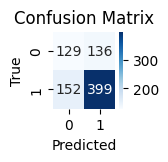

In [10]:
import classifiers.lgbm as lgbm

param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_train_lgbm(X_train, y_train, param=param)


vocab size: 12112
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   2.9s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.3s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample

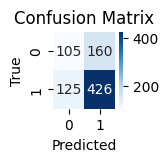

In [9]:
train, test = extr_feat(train_df, test_100_df, factor=True, n_comp=3/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_train_lgbm(X_train, y_train, param=param)


vocab size: 11961
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.1s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.2s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample

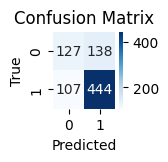

In [7]:
import classifiers.lgbm as lgbm

train, test = extr_feat(train_df, test_df, factor=True, n_comp=3/100, inductive=True)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_train_lgbm(X_train, y_train, param=param)


In [9]:
X_train.to_csv('data/evaluation/tf_idf_3_lgbm.csv', index=False)

vocab size: 14675
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.8s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample_bytree=0.6439425111081274, lgbmclassifier__learning_rate=0.02446899089623392, lgbmclassifier__max_depth=14, lgbmclassifier__min_data_in_leaf=43, lgbmclassifier__n_estimators=62, lgbmclassifier__num_leaves=61, lgbmclassifier__reg_alpha=4.213860228259545, lgbmclassifier__reg_lambda=6.02274552309317, lgbmclassifier__subsample=0.730710461923459; total time=   3.9s
[CV] END lgbmclassifier__boosting=gbdt, lgbmclassifier__colsample

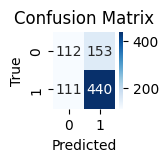

In [11]:
train, test = extr_feat(train_df, test_df, factor=True, n_comp=3/100, inductive=False)
X_train = train.drop(columns=['label'])
y_train = train['label']
param = {'lgbmclassifier__num_leaves': 61, 'lgbmclassifier__min_data_in_leaf': 43, 'lgbmclassifier__max_depth': 14, 'lgbmclassifier__learning_rate': 0.02446899089623392, 'lgbmclassifier__n_estimators': 62, 'lgbmclassifier__subsample': 0.730710461923459, 'lgbmclassifier__colsample_bytree': 0.6439425111081274, 'lgbmclassifier__reg_alpha': 4.213860228259545, 'lgbmclassifier__reg_lambda': 6.02274552309317, 'lgbmclassifier__boosting': 'gbdt'}
param = {k:[v] for k,v in param.items()}
gs, model= lgbm.fit_train_lgbm(X_train, y_train, param=param)
